Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
## Using google drive to connect to the Dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#unzip the dataset
!unzip /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment.zip -d /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/

Archive:  /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration

#### Data Reading & Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
#Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images available in train dataset:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images available in test dataset:", image_count_test)

Images available in train dataset: 2239
Images available in test dataset: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating Train and Validation datasets

Defining some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [10]:
#Loading the training data
#using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
#resizing the images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
#Loading the validation data
#using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
#resizing the images to the size img_height*img_width, while writing the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
##Listing out all the classes of skin cancer and store them in a list, These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print("The different types of cancer classes are: ")
print(class_names)

The different types of cancer classes are: 
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset



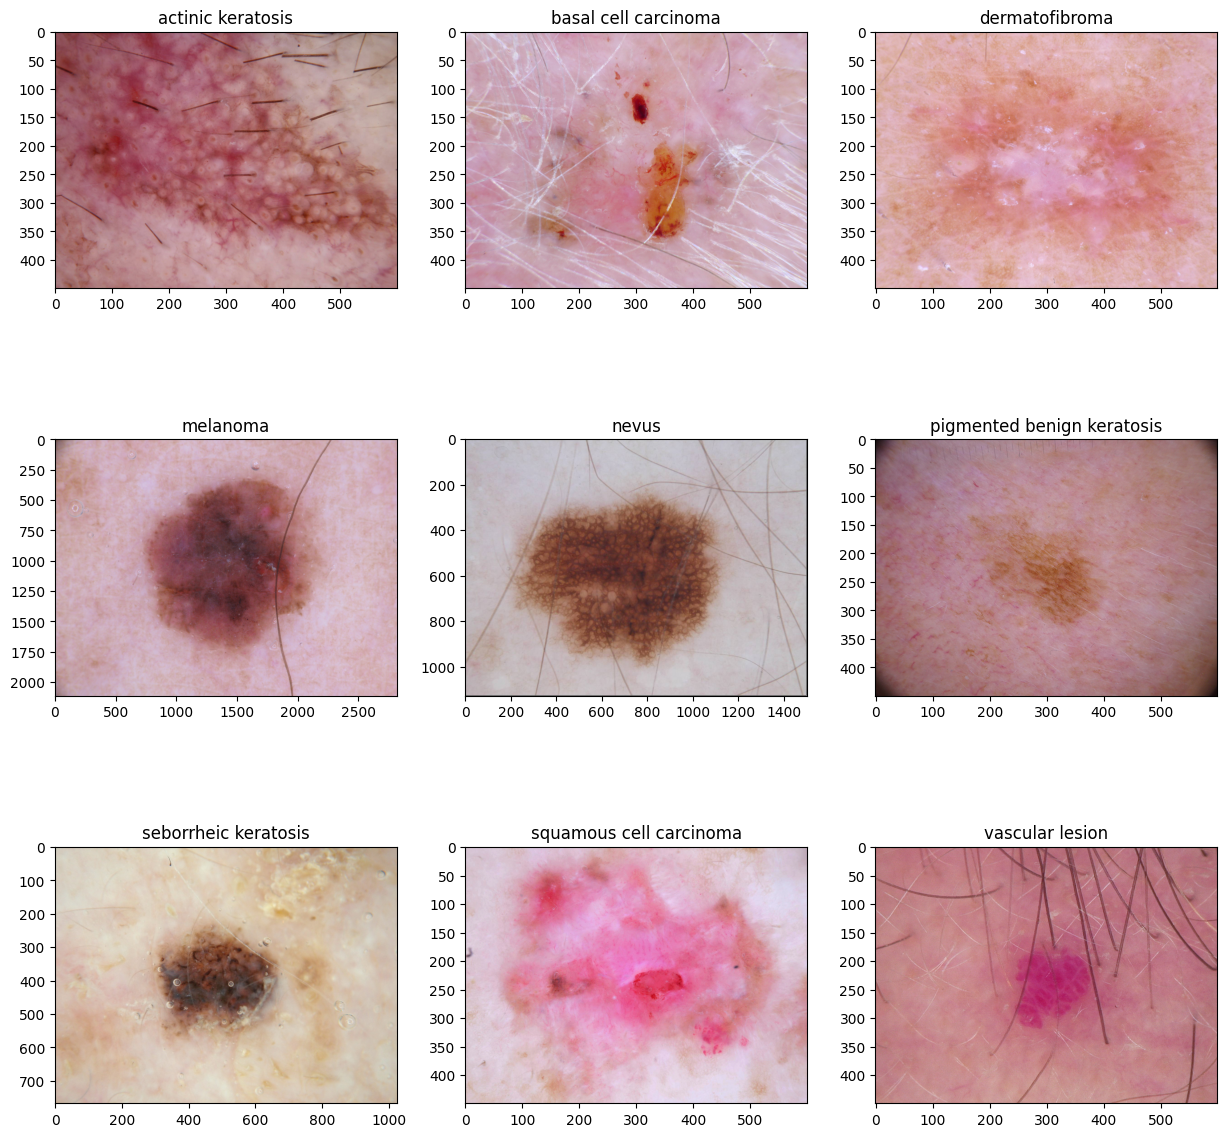

In [13]:
###visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(15,15))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range.

In [15]:
# Initial - CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Here we chose "adam" optimiser and "SparseCategoricalCrossentropy" loss function for model training 

In [16]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
#View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Training the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 100ms/step - loss: 2.1754 - accuracy: 0.2121 - val_loss: 1.9297 - val_accuracy: 0.3154
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.7515 - accuracy: 0.3778 - val_loss: 1.6340 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.4851 - accuracy: 0.4939 - val_loss: 1.4891 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3646 - accuracy: 0.5285 - val_loss: 1.4012 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 1.2651 - accuracy: 0.5564 - val_loss: 1.4119 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.1548 - accuracy: 0.5949 - val_loss: 1.3895 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 2s 36ms/step - loss: 1.0630 - accuracy: 0.6239 - val_loss: 1.5166 - val_accuracy: 0.4989
Epoch 8/20


### Visualizing training results

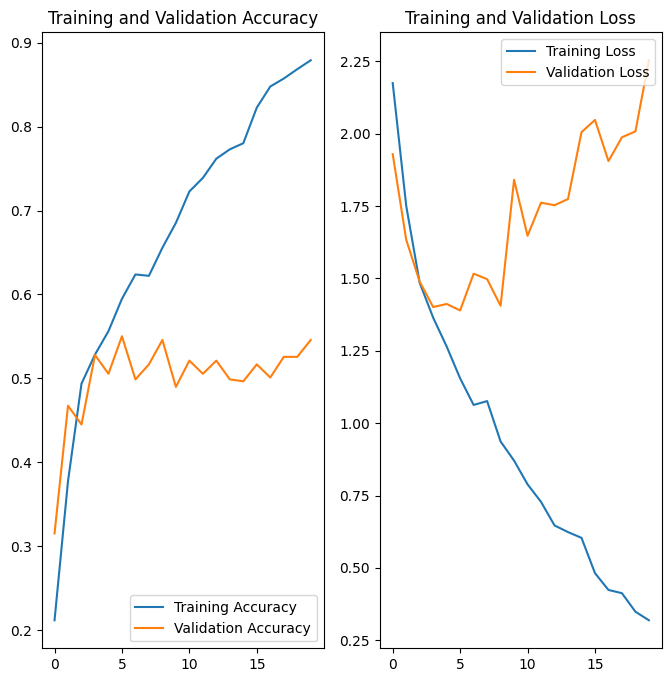

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
* As the number of epochs increase, the training accuracy increases whereas the validation accuracy stall at 50% accuracy in training process.
* As the training loss dereases with epochs the validation loss increases.
* Overall, the validation accuracy was around 50-55% for the model.
* The high training accuracy and low validation accuracy notified is a sign of overfitting.

Looks like the training data is insufficient for our model. So let's try some data augmentation strategy to come up with a bigger dataset

Image Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

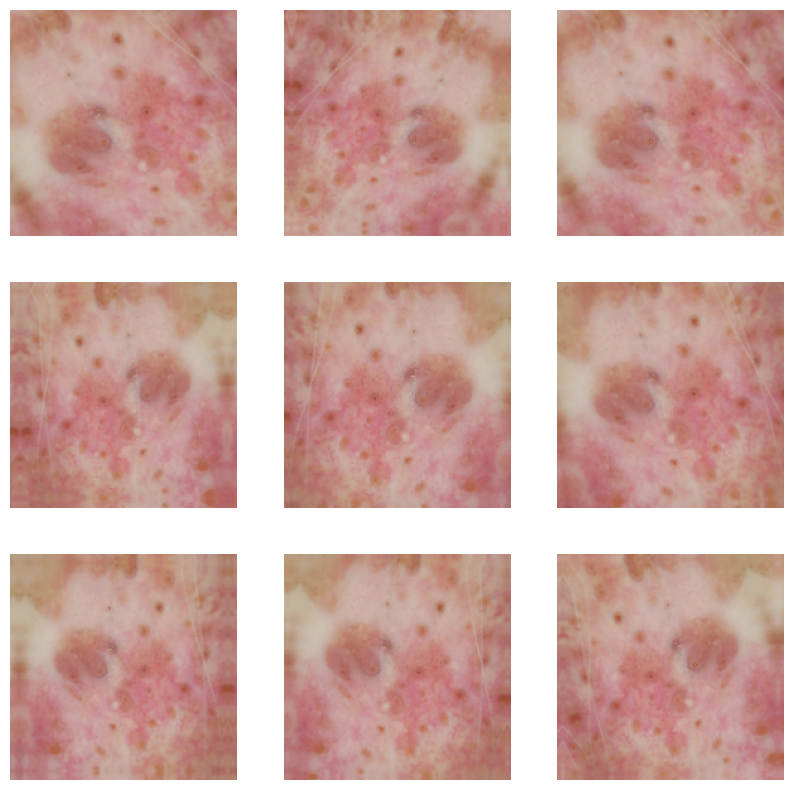

In [21]:
#visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model Building & training on the augmented data :


In [22]:
# CNN Model with data augmentation
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [23]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

### Training the model

In [24]:
#Model training
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 63ms/step - loss: 2.2590 - accuracy: 0.1903 - val_loss: 2.0192 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 2.0329 - accuracy: 0.2076 - val_loss: 1.9984 - val_accuracy: 0.3020
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.9477 - accuracy: 0.2980 - val_loss: 1.7972 - val_accuracy: 0.3579
Epoch 4/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7062 - accuracy: 0.3795 - val_loss: 1.6040 - val_accuracy: 0.4139
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.6356 - accuracy: 0.4135 - val_loss: 1.5932 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.5461 - accuracy: 0.4565 - val_loss: 1.6005 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4987 - accuracy: 0.4827 - val_loss: 1.5540 - val_accuracy: 0.4899
Epoch 8/20
56

### Visualizing the results

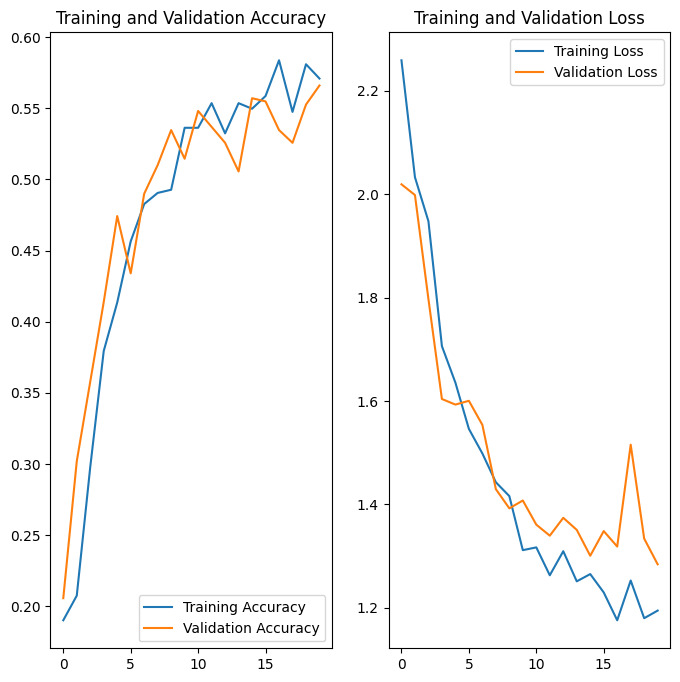

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:

* The overall accuracy is improved a little than the previous model.
* From the plot it can be observed that the gap between the training accuracy and the validation accuracy is much less now when compared to the initial model.
* This implies that the overfitting of the model is greatly reduced when compared to the previous model but the overall accuracy is not much great.

### Class Distribution

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Let's check the class distribution to see if all the classes(cancer types) are equally distributed.

In [26]:
## get the no of samples in each class
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


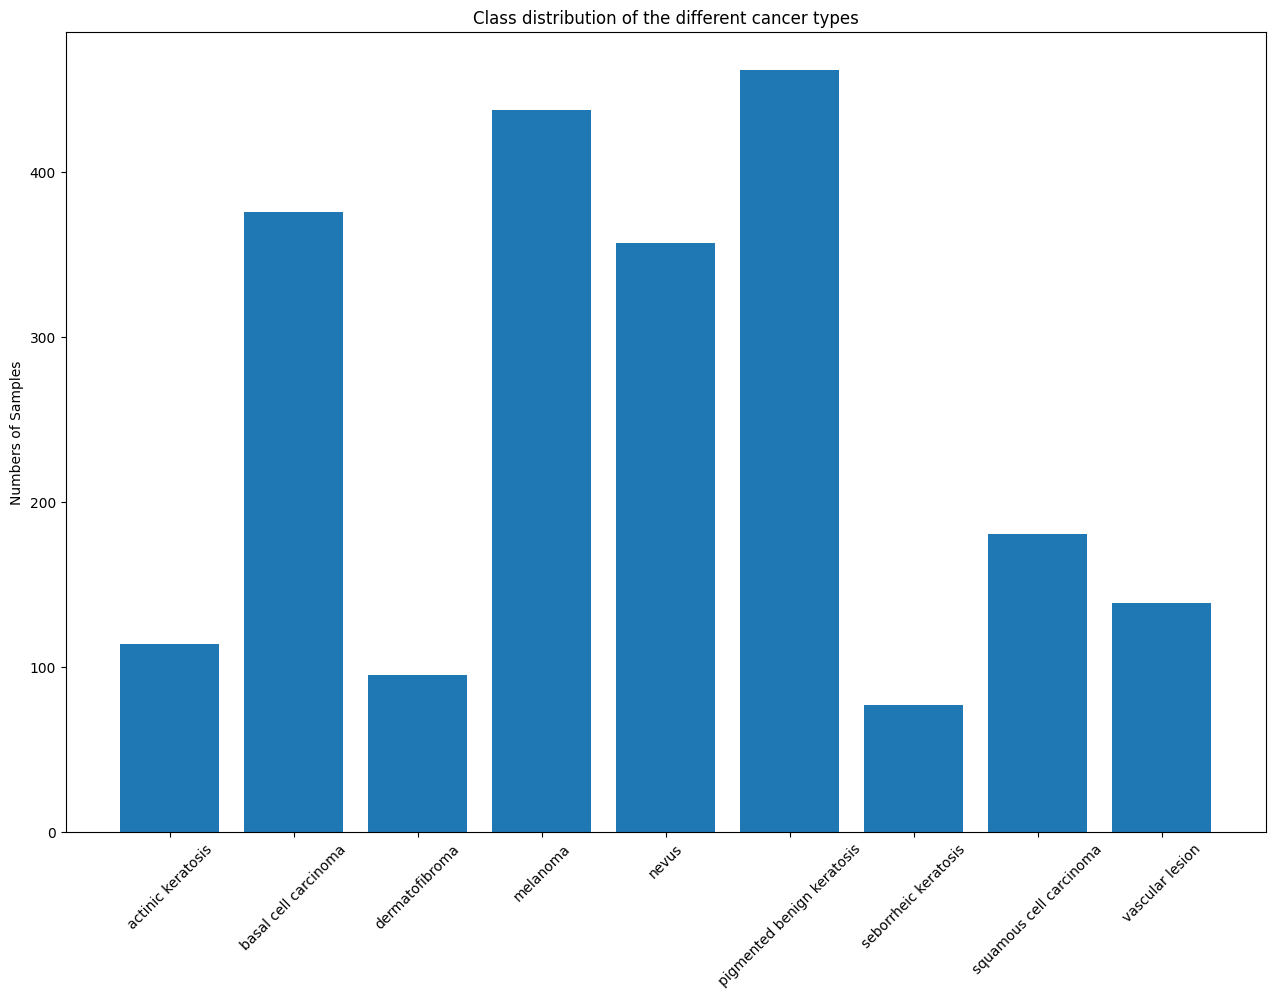

In [27]:
#plot the distribution to visualize
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of Samples')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

####Observation
#### - Which class has the least number of samples?
 The class **seborrheic keratosis** has the least number of samples with just 77 images. 
#### - Which classes dominate the data in terms proportionate number of samples?
  The class **pigmented benign keratosis** has the highest number of samples with 462 images.


### Handling class imbalances:

Rectifing class imbalances present in the training dataset with Augmentor library.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F20180AEC10>: 100%|██████████| 500/500 [00:28<00:00, 17.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2018050310>: 100%|██████████| 500/500 [00:30<00:00, 16.48 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F201805CEB0>: 100%|██████████| 500/500 [00:24<00:00, 20.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F20097C17C0>: 100%|██████████| 500/500 [02:01<00:00,  4.13 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F20910CF4C0>: 100%|██████████| 500/500 [01:50<00:00,  4.54 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F201809CB20>: 100%|██████████| 500/500 [00:23<00:00, 21.60 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2129A69220>: 100%|██████████| 500/500 [00:50<00:00,  9.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F20097EB8E0>: 100%|██████████| 500/500 [00:22<00:00, 22.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F209106AC10>: 100%|██████████| 500/500 [00:21<00:00, 23.36 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [33]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [34]:
batch_size = 32
img_height = 180
img_width = 180

In [35]:
#creating training dataset
data_dir_train="/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
#creating Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Train the model on the data created using Augmentor

In [38]:
# CNN Model on the data created using Augmentor
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [39]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

In [40]:
#Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 102ms/step - loss: 1.9131 - accuracy: 0.2869 - val_loss: 1.5004 - val_accuracy: 0.4172
Epoch 2/30
169/169 [==============================] - 10s 57ms/step - loss: 1.4475 - accuracy: 0.4525 - val_loss: 1.3068 - val_accuracy: 0.4759
Epoch 3/30
169/169 [==============================] - 10s 56ms/step - loss: 1.2841 - accuracy: 0.5167 - val_loss: 1.1015 - val_accuracy: 0.5605
Epoch 4/30
169/169 [==============================] - 9s 56ms/step - loss: 1.1678 - accuracy: 0.5558 - val_loss: 1.0264 - val_accuracy: 0.6058
Epoch 5/30
169/169 [==============================] - 9s 56ms/step - loss: 1.0044 - accuracy: 0.6358 - val_loss: 0.9762 - val_accuracy: 0.6333
Epoch 6/30
169/169 [==============================] - 9s 56ms/step - loss: 0.9216 - accuracy: 0.6665 - val_loss: 0.8262 - val_accuracy: 0.6941
Epoch 7/30
169/169 [==============================] - 9s 56ms/step - loss: 0.8078 - accuracy: 0.7010 - val_loss: 0.7813 - val_accuracy: 0.

#### Visualize the model results for the Augmented Model

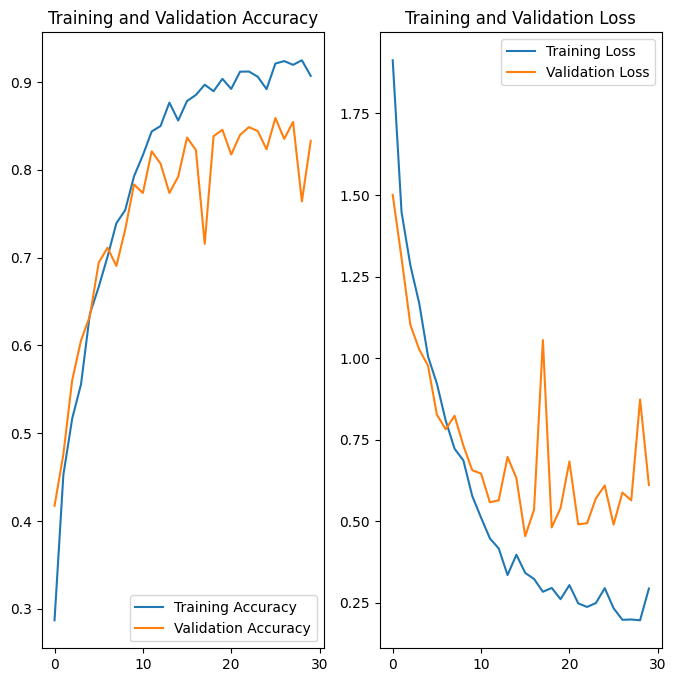

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation
* With the increase in the training accuracy over time, where as the validation accuracy also increases.
* As the training loss decreases with epochs the validation loss also decreases.
* The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 83% accuracy on the validation set.

Finally, **Class rebalancing not only got rid of overfitting it also improved the overall accuracy from 55% to 83% and also reduced the overall loss.**